In [974]:
import sys
sys.path.append("../code/")

from importlib import reload  
import lib_LinearAlgebra
lib_LinearAlgebra = reload(lib_LinearAlgebra)

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats

# Simulate with intercept

In [977]:
n = 100
k = 3
n_outcome = 4
kcovar = 2
beta = np.reshape(np.array(range(1, k * n_outcome + 1)), newshape = [k, n_outcome])
bcovar = np.reshape(np.array(range(1, kcovar * n_outcome + 1)), newshape = [kcovar, n_outcome]) * 0.2
intercepts = np.array([230, 250, 270, 290])

x = np.random.normal(size = [n, k])
covar = np.random.normal(size = [n, kcovar])
y = np.matmul(x, beta) + np.matmul(covar, bcovar) + np.random.normal(size = [n, n_outcome]) + intercepts

In [978]:
dataset = tf.data.Dataset.from_tensor_slices((x, np.concatenate((y, covar), axis = 1)))
dataset = dataset.map(lambda x, y: (tf.cast(x, tf.float32), tf.cast(y, tf.float32)))

In [979]:
dataset = dataset.batch(7)

In [980]:
data_scheme = lib_LinearAlgebra.DataScheme(
    dataset = dataset, 
    X_index = 0,
    Y_index = 1,
    outcome_indice = [0, 1, 2, 3], 
    covariate_indice = [4, 5]
)

## The right thing

In [981]:
least_square_solver = lib_LinearAlgebra.LeastSquaredEstimator(data_scheme, intercept = True)

In [982]:
least_square_solver.solve()

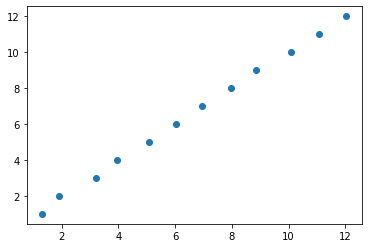

In [983]:
plt.scatter(least_square_solver.get_betahat_x(), beta)

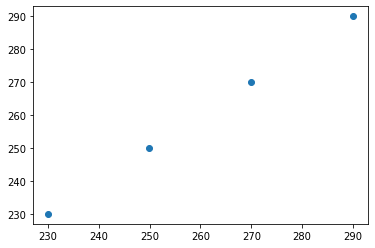

In [984]:
plt.scatter(least_square_solver.get_intercept(), intercepts)

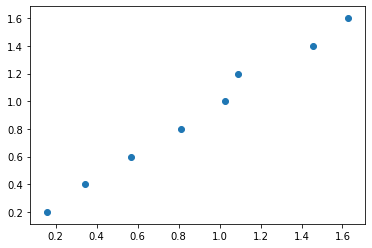

In [985]:
plt.scatter(least_square_solver.get_betahat_covar(), bcovar)

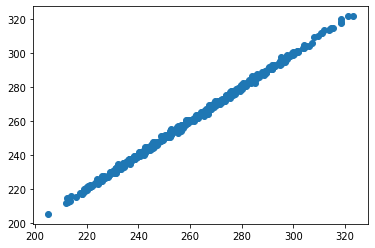

In [986]:
y_pred = least_square_solver.predict(dataset)
plt.scatter(y_pred['y_pred'], y_pred['y'])

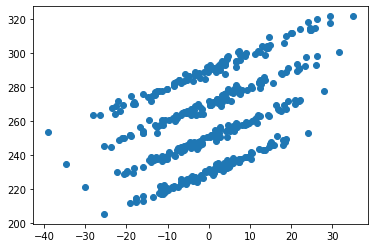

In [987]:
y_pred = least_square_solver.predict_x(dataset)
plt.scatter(y_pred['y_pred_from_x'], y_pred['y'])

## No intercept

In [988]:
least_square_solver = lib_LinearAlgebra.LeastSquaredEstimator(data_scheme, intercept = False)
least_square_solver.solve()

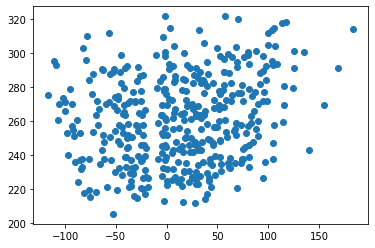

In [989]:
y_pred = least_square_solver.predict(dataset)
plt.scatter(y_pred['y_pred'], y_pred['y'])

# Simulate without intercept

In [990]:
n = 100
k = 3
n_outcome = 4
kcovar = 2
beta = np.reshape(np.array(range(1, k * n_outcome + 1)), newshape = [k, n_outcome])
bcovar = np.reshape(np.array(range(1, kcovar * n_outcome + 1)), newshape = [kcovar, n_outcome]) * 0.2
# intercepts = np.array([230, 250, 270, 290])

x = np.random.normal(size = [n, k])
covar = np.random.normal(size = [n, kcovar])
y = np.matmul(x, beta) + np.matmul(covar, bcovar) + np.random.normal(size = [n, n_outcome]) # + intercepts

dataset = tf.data.Dataset.from_tensor_slices((x, np.concatenate((y, covar), axis = 1)))
dataset = dataset.map(lambda x, y: (tf.cast(x, tf.float32), tf.cast(y, tf.float32)))
dataset = dataset.batch(7)
data_scheme = lib_LinearAlgebra.DataScheme(
    dataset = dataset, 
    X_index = 0,
    Y_index = 1,
    outcome_indice = [0, 1, 2, 3], 
    covariate_indice = [4, 5]
)

## With intercept

In [991]:
least_square_solver = lib_LinearAlgebra.LeastSquaredEstimator(data_scheme, intercept = True)
least_square_solver.solve()


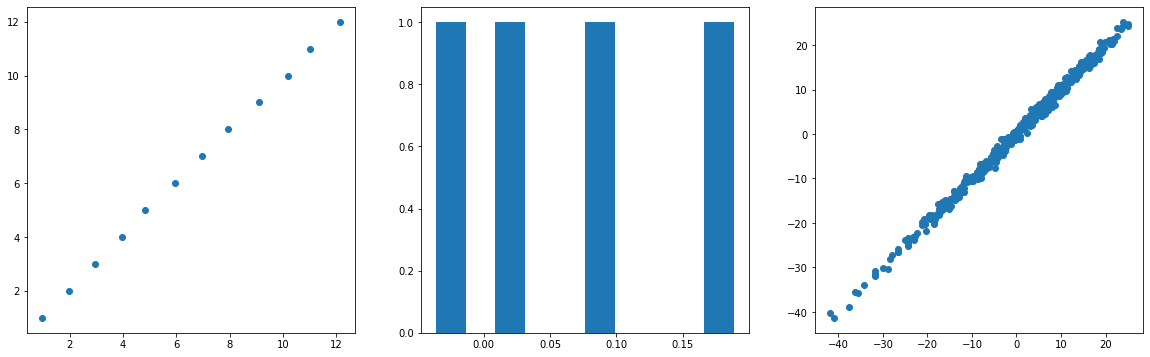

In [992]:
fig, axe = plt.subplots(ncols = 3, nrows = 1, figsize = (20, 6))
axe[0].scatter(least_square_solver.get_betahat_x(), beta)
axe[1].hist(least_square_solver.get_intercept())
y_pred = least_square_solver.predict(dataset)
axe[2].scatter(y_pred['y_pred'], y_pred['y'])

## Without intercept

In [993]:
least_square_solver = lib_LinearAlgebra.LeastSquaredEstimator(data_scheme, intercept = False)
least_square_solver.solve()


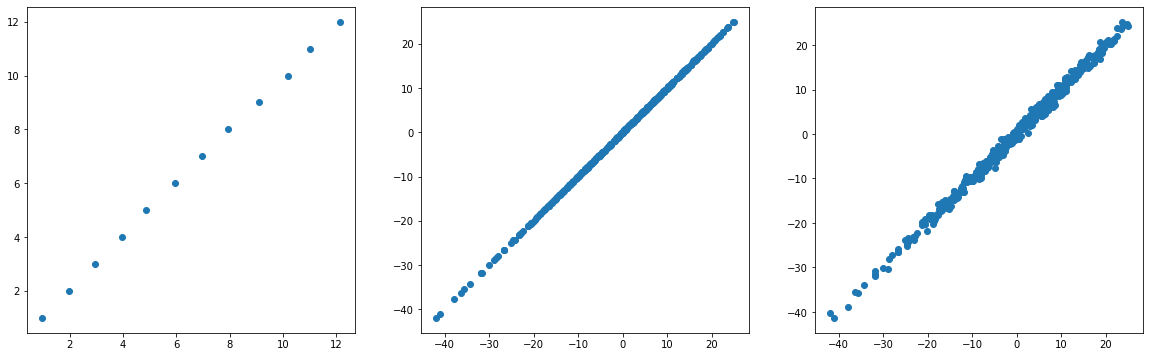

In [994]:
fig, axe = plt.subplots(ncols = 3, nrows = 1, figsize = (20, 6))
axe[0].scatter(least_square_solver.get_betahat_x(), beta)
y_pred2 = least_square_solver.predict(dataset)
axe[1].scatter(y_pred2['y_pred'], y_pred['y_pred'])
axe[2].scatter(y_pred2['y_pred'], y_pred2['y'])

# Testing minimal save and load

Saving betahat
Saving intercept
Saving normalizer
Saving data_scheme.dataset
Saving data_scheme.X_index
Saving data_scheme.Y_index
Saving data_scheme.outcome_indice
Saving data_scheme.covariate_indice
Saving data_scheme.num_predictors
DescribeResult(nobs=100, minmax=(array([0., 0., 0., 0.], dtype=float32), array([0., 0., 0., 0.], dtype=float32)), mean=array([0., 0., 0., 0.], dtype=float32), variance=array([0., 0., 0., 0.], dtype=float32), skewness=array([0., 0., 0., 0.], dtype=float32), kurtosis=array([-3., -3., -3., -3.], dtype=float32))
DescribeResult(nobs=100, minmax=(array([0., 0., 0., 0.], dtype=float32), array([0., 0., 0., 0.], dtype=float32)), mean=array([0., 0., 0., 0.], dtype=float32), variance=array([0., 0., 0., 0.], dtype=float32), skewness=array([0., 0., 0., 0.], dtype=float32), kurtosis=array([-3., -3., -3., -3.], dtype=float32))


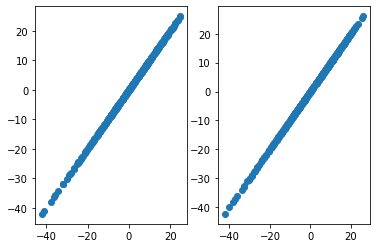

In [995]:
least_square_solver.minimal_save('test.hdf5')
loaded_solver = lib_LinearAlgebra.LeastSquaredEstimator('')
loaded_solver.minimal_load('test.hdf5')

y_pred2_x = loaded_solver.predict_x(dataset)
y_pred2 = loaded_solver.predict(dataset)

y_pred_x = least_square_solver.predict_x(dataset)
y_pred = least_square_solver.predict(dataset)

fig, axe = plt.subplots(nrows = 1, ncols = 2)
axe[0].scatter(y_pred['y_pred'], y_pred2['y_pred'])
axe[1].scatter(y_pred_x['y_pred_from_x'], y_pred2_x['y_pred_from_x'])
print(scipy.stats.describe(y_pred['y_pred'] - y_pred2['y_pred']))
print(scipy.stats.describe(y_pred_x['y_pred_from_x'] - y_pred2_x['y_pred_from_x']))

# Testing scaling

In [996]:
least_square_solver_noscale = lib_LinearAlgebra.LeastSquaredEstimator(data_scheme, intercept = False)
least_square_solver_noscale.solve(scaling = False)

In [997]:
least_square_solver_noscale.betahat / least_square_solver.betahat

<tf.Tensor: shape=(5, 4), dtype=float32, numpy=
array([[0.9999994 , 0.9999995 , 0.99999994, 0.99999976],
       [1.0000008 , 1.0000006 , 1.0000004 , 1.0000002 ],
       [1.0000001 , 0.9999999 , 0.99999994, 0.99999994],
       [0.99999756, 0.99999833, 0.9999988 , 0.99999857],
       [1.0000013 , 1.0000008 , 1.0000008 , 1.0000002 ]], dtype=float32)>

# Testing logging

In [998]:
import logging, sys
logging.basicConfig(
    level = logging.INFO, 
    stream = sys.stderr, 
    format = '%(asctime)s  %(message)s',
    datefmt = '%Y-%m-%d %I:%M:%S %p'
)
least_square_solver_noscale.solve(logging = logging, sample_size = 100)

2020-01-27 11:26:46 AM  Progress 5%: 7 / 100
2020-01-27 11:26:46 AM  Progress 10%: 14 / 100
2020-01-27 11:26:46 AM  Progress 20%: 21 / 100
2020-01-27 11:26:46 AM  Progress 25%: 28 / 100
2020-01-27 11:26:46 AM  Progress 30%: 35 / 100
2020-01-27 11:26:46 AM  Progress 40%: 42 / 100
2020-01-27 11:26:46 AM  Progress 45%: 49 / 100
2020-01-27 11:26:46 AM  Progress 55%: 56 / 100
2020-01-27 11:26:46 AM  Progress 60%: 63 / 100
2020-01-27 11:26:46 AM  Progress 65%: 70 / 100
2020-01-27 11:26:46 AM  Progress 75%: 77 / 100
2020-01-27 11:26:46 AM  Progress 80%: 84 / 100
2020-01-27 11:26:46 AM  Progress 90%: 91 / 100
2020-01-27 11:26:46 AM  Progress 95%: 98 / 100
2020-01-27 11:26:46 AM  Progress 100%: 100 / 100


# Testing full normalization

In [999]:
n = 200
k = 300
n_outcome = 4
kcovar = 7
beta = np.reshape(np.array(range(1, k * n_outcome + 1)), newshape = [k, n_outcome])
bcovar = np.reshape(np.array(range(1, kcovar * n_outcome + 1)), newshape = [kcovar, n_outcome]) * 0.2
intercepts = np.array([230, 250, 270, 290])

x = np.random.normal(size = [n, k])
covar = np.random.normal(size = [n, kcovar])
y = np.matmul(x, beta) + np.matmul(covar, bcovar) + np.random.normal(size = [n, n_outcome]) + intercepts

dataset = tf.data.Dataset.from_tensor_slices((x, np.concatenate((y, covar), axis = 1)))
dataset = dataset.map(lambda x, y: (tf.cast(x, tf.float32), tf.cast(y, tf.float32)))
dataset = dataset.batch(300)
data_scheme = lib_LinearAlgebra.DataScheme(
    dataset = dataset, 
    X_index = 0,
    Y_index = 1,
    outcome_indice = [0, 1, 2, 3], 
    covariate_indice = [4, 5]
)

least_square_solver = lib_LinearAlgebra.LeastSquaredEstimator(data_scheme, intercept = True)
least_square_solver.solve()

least_square_solver_batch = lib_LinearAlgebra.LeastSquaredEstimator(data_scheme, intercept = True, normalizer = True)
norm = least_square_solver_batch.solve(return_normalizer = True)

In [1000]:
mean = np.array(norm.mean)
std = np.array(norm.std)

beta_old = least_square_solver_batch.betahat[:,0][1:] / std
intercept_old = least_square_solver_batch.betahat[:,0][0] - sum(mean / std * least_square_solver_batch.betahat[:,0][1:])

# least_square_solver_batch.betahat[:,0][0]

tmp = mean / std * least_square_solver_batch.betahat[:,0][1:]
print(sum(tmp[:3]))

print(intercept_old - least_square_solver.betahat[:,0][0])

print(least_square_solver_batch.betahat[:,0][1:] / std - least_square_solver.betahat[:,0][1:])

tf.Tensor(82.62909, shape=(), dtype=float32)
tf.Tensor(-245.22137, shape=(), dtype=float32)
tf.Tensor(
[ 7.07678223e+01  1.84954224e+01  3.11175919e+01 -2.28304291e+01
  5.22368164e+01  1.13401337e+01 -1.74464111e+01  4.34565277e+01
  4.49914551e+00 -3.31388855e+01 -1.49896088e+01 -2.22338867e+01
  4.18955917e+01 -2.12589226e+01  4.75664902e+00  3.36277466e+01
 -4.51748047e+01  3.20063171e+01 -1.12733765e+01  1.82578697e+01
  5.43148956e+01  7.87454224e+00 -2.72653198e+00  4.43032875e+01
  1.97819214e+01 -1.27246552e+01  1.94125061e+01  1.07742920e+01
 -2.57012749e+01  4.80915833e+00  1.88621979e+01 -3.19397688e+00
  4.15274429e+01 -1.39468536e+01 -7.82795639e+01  5.19826660e+01
 -3.86682281e+01  7.22796631e+00  3.69808655e+01 -4.54734802e+00
  7.30116348e+01 -1.82939911e+01  2.24702148e+01  2.12270813e+01
  7.06901855e+01 -4.50572014e-01  2.64863281e+01  3.01497498e+01
  3.44230957e+01 -1.87009583e+01 -1.35299377e+01 -1.43999939e+01
  1.90150146e+01  4.15263672e+01 -1.03097534e+00 -2.

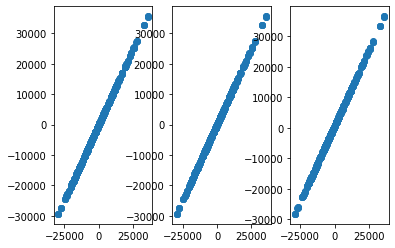

In [1001]:
y_pred = least_square_solver.predict(dataset)
y_pred_b = least_square_solver_batch.predict(dataset)

y_pred_x = least_square_solver.predict_x(dataset)
y_pred_b_x = least_square_solver_batch.predict_x(dataset)

fig, axe = plt.subplots(nrows = 1, ncols = 3)
axe[0].scatter(y_pred['y'], y_pred['y_pred'])
axe[1].scatter(y_pred['y_pred'], y_pred_b['y_pred'])
axe[2].scatter(y_pred_x['y_pred_from_x'], y_pred_b_x['y_pred_from_x'])


In [1002]:
least_square_solver.normalizer

False

In [1003]:
for x in dataset:
    print(x[0].shape)

(200, 300)


In [1004]:
print(abs(y_pred_b['y_pred'] - y_pred_b['y']) - abs(y_pred['y_pred'] - y_pred['y']))

[[ 0.00683594  0.01367188  0.00390625  0.01074219]
 [ 0.00146484  0.01464844  0.0078125   0.00732422]
 [-0.00488281 -0.00878906  0.         -0.00488281]
 [ 0.         -0.00195312  0.00976562  0.01171875]
 [ 0.0078125  -0.00390625  0.00976562  0.0078125 ]
 [-0.00585938 -0.00976562 -0.00390625 -0.00976562]
 [ 0.00585938  0.00097656  0.         -0.00097656]
 [-0.00097656  0.00244141  0.00097656 -0.00390625]
 [-0.0222168  -0.01196289 -0.01416016 -0.01025391]
 [ 0.00683594  0.01123047  0.00976562  0.00585938]
 [ 0.00292969 -0.00195312 -0.00390625  0.00195312]
 [-0.00195312  0.00097656  0.00146484 -0.00390625]
 [-0.00439453  0.00170898 -0.00415039 -0.00878906]
 [ 0.0078125   0.          0.         -0.00195312]
 [ 0.         -0.00585938  0.00390625  0.0078125 ]
 [ 0.00292969  0.00097656 -0.00488281  0.00488281]
 [-0.00195312 -0.0065918  -0.01049805 -0.00610352]
 [ 0.00292969 -0.00683594 -0.01367188 -0.01074219]
 [ 0.00097656  0.00390625  0.00585938 -0.00585938]
 [-0.02636719 -0.00732422 -0.02

In [1005]:
print(abs(y_pred_b_x['y_pred_from_x'] - y_pred_b_x['y']) - abs(y_pred_x['y_pred_from_x'] - y_pred_x['y']))

[[ 500.36035   496.01758   491.4502    486.89258 ]
 [ 544.1172    539.05566   533.7749    528.5303  ]
 [ 572.4956    568.17773   563.6675    559.1489  ]
 [ 553.4551    549.8301    546.0078    542.15234 ]
 [ 489.79297   485.3828    480.7422    476.16406 ]
 [ 525.5586    521.3164    516.8672    512.41406 ]
 [ 500.70996   495.87012   490.82422   485.79492 ]
 [ 553.208     548.70605   543.9785    539.26855 ]
 [ 599.3408    593.28516   587.0405    580.833   ]
 [ 544.4492    539.41895   534.1831    528.97363 ]
 [ 565.5547    560.68555   555.6113    550.56055 ]
 [ 565.0923    560.6089    555.9219    551.2285  ]
 [ 518.67456   514.3733    509.85254   505.36646 ]
 [ 537.7363    534.03125   530.11523   526.18164 ]
 [ 547.18945   543.6738    539.9668    536.2285  ]
 [ 507.51904   501.71777   495.69434   489.75488 ]
 [ 564.6387    559.96484   555.0996    550.2473  ]
 [ 487.86426   483.70703   479.34863   474.9746  ]
 [ 531.41504   526.5       521.375     516.291   ]
 [ 479.80713   475.83105   471.

In [1006]:
# tf.reduce_sum(tf.multiply(least_square_solver.svd.v[:,0], least_square_solver.svd.v[:,1]))
# least_square_solver.svd.v

# Testing partial R2

In [1007]:
n = 200
k = 3
n_outcome = 4
kcovar = 10
beta = np.reshape(np.array(range(1, k * n_outcome + 1)), newshape = [k, n_outcome])
bcovar = np.reshape(np.array(range(1, kcovar * n_outcome + 1)), newshape = [kcovar, n_outcome]) * 0.2
intercepts = np.array([230, 250, 270, 290])

x = np.random.normal(size = [n, k])
covar = np.random.normal(size = [n, kcovar])
y = np.matmul(x, beta) + np.matmul(covar, bcovar) + np.random.normal(size = [n, n_outcome]) + intercepts

dataset = tf.data.Dataset.from_tensor_slices((x, np.concatenate((y, covar), axis = 1)))
dataset = dataset.map(lambda x, y: (tf.cast(x, tf.float32), tf.cast(y, tf.float32)))
dataset = dataset.batch(300)
data_scheme = lib_LinearAlgebra.DataScheme(
    dataset = dataset, 
    X_index = 0,
    Y_index = 1,
    outcome_indice = [0, 1, 2, 3], 
    covariate_indice = [4, 5]
)

least_square_solver = lib_LinearAlgebra.LeastSquaredEstimator(data_scheme, intercept = True)
least_square_solver.solve()

least_square_solver_batch = lib_LinearAlgebra.LeastSquaredEstimator(data_scheme, intercept = True, normalizer = True)
norm = least_square_solver_batch.solve(return_normalizer = True)
least_square_solver.data_scheme.covariate_indice

[4, 5]

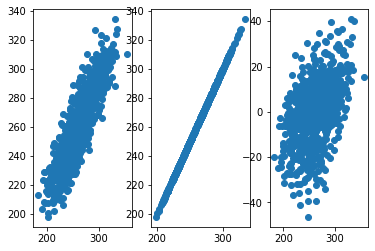

In [1008]:
y_pred = least_square_solver.predict(dataset)
y_pred_b = least_square_solver_batch.predict(dataset)

y_pred_x = least_square_solver.predict_x(dataset)
y_pred_b_x = least_square_solver_batch.predict_x(dataset)

fig, axe = plt.subplots(nrows = 1, ncols = 3)
axe[0].scatter(y_pred['y'], y_pred['y_pred'])
axe[1].scatter(y_pred['y_pred'], y_pred_b['y_pred'])
axe[2].scatter(y_pred_x['y'], y_pred_x['y_pred_from_x'])

In [1009]:
least_square_solver.partial_r2(dataset, logging = logging)
# y_pred_b_x['y_pred_from_x'][(0,1)]
# dataset.element_spec

2020-01-27 11:26:47 AM  Partial R2 Processing 0 / 4
2020-01-27 11:26:47 AM  now processing outcome index 0
2020-01-27 11:26:48 AM  Partial R2 Processing 1 / 4
2020-01-27 11:26:48 AM  now processing outcome index 1
2020-01-27 11:26:48 AM  Partial R2 Processing 2 / 4
2020-01-27 11:26:48 AM  now processing outcome index 2
2020-01-27 11:26:48 AM  Partial R2 Processing 3 / 4
2020-01-27 11:26:48 AM  now processing outcome index 3


array([[4.30747747e-01, 3.44159570e+04, 6.04581836e+04],
       [4.76209283e-01, 3.75286445e+04, 7.16481641e+04],
       [5.10234714e-01, 3.98466016e+04, 8.13585625e+04],
       [5.46580911e-01, 4.29707422e+04, 9.47704688e+04]])